In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from numpy import linalg

from matplotlib import animation, rc
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from IPython.display import HTML, Image, set_matplotlib_formats
set_matplotlib_formats('png','pdf')

rc('animation', html='html5')

Étant donnée la nature numériquement intensive des calculs tensoriels en jeu, on aura besoin de la librairie `numba` qui passe par le langage `C` pour compiler des fonctions plus rapides *on the fly*:

In [4]:
import numba as nb
from numba import double, int32, float32

On cherche à résoudre l'équation de la chaleur en deux dimensions,
$$
\frac{\partial u}{\partial t} = D\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) + q(x,y,t)
$$
sur un domaine $\Omega = [-L_x,L_x]\times[-L_y,L_y]$.

Ce document sert de documentation pour les scripts Python permettant de simuler numériquement le transfert thermique dans un domaine bidimensionnel uniforme.

# Schéma de résolution : différences finies

## Discrétisation

On va chercher une solution approchée $\left(u_{i,j}^n\right)$ de l'EDP sur une grille $(x_i,y_j)$, en temps discrétisé $(t_n)$.

Il faut discrétiser les opérateurs différentiels. On discrétise la dérivée temporelle par
$$
\frac{\partial u}{\partial t} \approx \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}
$$
et le Laplacien par
$$
\Delta u(x_i,y_j,t_n) \approx \frac{u_{i+1,j}^{n+1}+u_{i,j+1}^{n+1}+u_{i-1,j}^{n+1}+u_{i,j-1}^{n+1}-4u_{i,j}^{n+1}}{h^2}
$$

Posons $r=\frac{D\Delta t}{h^2}$. On obtient alors le système linéaire:
$$
(1+4r)u_{i,j}^{n+1} - ru_{i+1,j}^{n+1} - ru_{i,j+1}^{n+1} -ru_{i-1,j}^{n+1}-ru_{i,j-1}^{n+1}=
u_{i,j}^n
$$

Mais il n'a pas trop de sens au bord du domaine. Pour cela, on va utiliser nos conditions aux limites.

Pour imposer une condition aux limites de type Dirichlet $f:\partial\Omega\times I\rightarrow\mathbb R$, on la discrétise et on répercute en imposant les valeurs $u_{0,j}^n$, $u_{N-1,j}^n$, $u_{i,0}^n$ et $u_{i,N-1}^n$ dans le système d'équations.

## Tenseurs d'état et de transition

On pose
$$
\mathbf U^n = (u_{i,j})_{0\le i,j\le N-1}
$$
la matrice d'état du système à l'instant $t_n$.

Le système linéaire précédent lie l'état du système à l'instant $t_n$, $\mathbf U^{n}$, à son état $\mathbf U^{n+1}$ à l'instant suivant. On va essayer de représenter cette relation d'une façon efficace du point de vue informatique.

On cherche un tenseur de « *transition* » $\mathbf T = \left(t_{i,j}^{k,l}\right)$ tel que
$$
u_{i,j}^{n} = t^{k,l}_{i,j} u_{k,l}^{n+1}
$$
pour $(i,j)$ en dehors des bords, avec la convention de sommation d'Einstein.

On prend $t^{k,l}_{i,j} = -r$ si $(k,l)=(i\pm 1, j\pm 1)$, $1+4r$ si $(k,l) = (i,j)$ en dehors des bords, $1$ aux bords et $0$ ailleurs.

On imposera manuellement les conditions aux bords à chaque étape.

On munit $\mathcal M_J(\mathbb R)$ de la base $\left(E_{i,j}\right)$ organisée dans l'ordre lexicographique. Dans cette base, l'endomorphisme $\mathbf U\longmapsto \mathbf T\mathbf U$ a pour matrice la matrice bloc
$$
A = \begin{bmatrix}
A_{0,0} & \cdots & A_{0,J-1} \\
\vdots  &        & \vdots \\
A_{J-1,0} & \dots & A_{J-1,J-1}
\end{bmatrix}
$$
où les $A_{j,k} = \left(t_{i,j}^{k,l}\right)_{0\le i,l < J}$ pour tous $0\le j,k< J$.

# Implémentation en Python

## Discrétisation : Classe `Domain`

La classe suivante permet de représenter le domaine spatial et temporel discrétisé, avec les attributs relatifs aux paramètres de grille (nombre de points, pas, bornes...).

In [19]:
class Domain():
    """
    Définit le domaine spatio-temporel du problème
    """
    def __init__(self, L, T, J = 64, N=250):
        # Éléments spatiaux
        self.L = L # intervalle où simuler
        self.J = J # Taille des échantillons spatiaux
        self.Xs = np.linspace(-L,L,J)
        self.Ys = np.linspace(-L,L,J)
        self.grid = np.meshgrid(self.Xs, self.Ys)
        self.dx = 2*L/J
        
        # Éléments temporels
        self.T = T # temps de la simulation numérique
        self.N = N # Taille des échantillons temporels
        self.times = np.linspace(0,T,N)
        self.dt = T/N
    
    def __call__(self):
        return self.grid

## Tenseur $\mathbf T$

La fonction suivante calcule l'inverse du tenseur $\mathbf T$ permettant d'itérer la relation de récurrence précédente.

In [6]:
def tenseur(J, dx, dt, diffus = 117e-6):
    """
    diffus : valeur du coefficient de diffusion
    valeur par défaut: cuivre, 117E-6 m²/s
    """
    tens = np.zeros((J,J,J,J))
    r = diffus*dt/dx**2
    for i in range(J):
        for j in range(J):
            a = i in [0,J-1]
            b = j in [0,J-1]
            if a or b:
                tens[i][j][i][j] = 1
            else:
                tens[i][j][i][j] = 1+4*r
                tens[i][j][i-1][j] = -r
                tens[i][j][i+1][j] = -r
                tens[i][j][i][j-1] = -r
                tens[i][j][i][j+1] = -r
    return tens

Il faut maintenant construire la matrice $A$, qui sera bien plus rapide à inverser que le tenseur directement :

In [7]:
def to_matrix(tens):
    J,_,_,_ = np.shape(tens)
    arr = np.zeros((J**2,J**2))
    for k in range(J):
        for j in range(J):
            arr[j*J:(j+1)*J,k*J:(k+1)*J] = tens[:,j,k,:]
    return arr

## Fonction `graphe`

Simple fonction qui dessine le profil d'une fonction sur $\Omega$.

In [8]:
def graphe(Omega, U0):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.grid(True)
    ax.plot_wireframe(*Omega.grid, U0)

Un petit test:

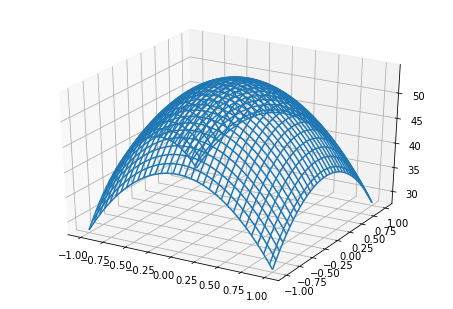

In [9]:
Omega = Domain(1,2,64,128)

U0 = 25+3*(lambda x,y: 10-(5*x**2+4*y**2))(*Omega.grid)

graphe(Omega, U0)

## Conditions de Dirichlet

Une fonction qui prend une matrice d'état et impose ses valeurs au bord.

In [10]:
def enforceDirich(Omega, state, f, n):
    """
    Impose les conditions aux limites de Dirichlet à l'instant t_n
    """
    J = Omega.J
    Xs = Omega.Xs
    Ys = Omega.Ys
    times = Omega.times
    for i in range(J):
        state[i][0] = f(Xs[i], Ys[0], times[n])
        state[i][J-1] = f(Xs[i], Ys[J-1], times[n])
    for j in range(J):
        state[0][j] = f(Xs[0], Ys[j], times[n])
        state[J-1][j] = f(Xs[J-1], Ys[j], times[n])

## Itération de la relation de récurrence

Il s'agit d'un simple passage dans une boucle en itérant sur les temps discrets, donnés par l'attribut `times` du domaine passé en argument. Pour ça, on va utiliser une classe `Solver` dont la méthode `solve` effectue la résolution.

In [11]:
class Solver:
    
    def __init__(self, Omega, U0, f):
        self.domain = Omega
        self.initial = U0
        self.boundfunc = f
        J = Omega.J
        dx = Omega.dx
        dt = Omega.dt
        self.tensor = tenseur(J,dx,dt)
        self.matrix = linalg.inv(to_matrix(self.tensor))
        
    def solve(self):
        times = self.domain.times
        Omega = self.domain
        J = Omega.J
        N = Omega.N
        dx = Omega.dx
        dt = Omega.dt
        U0 = self.initial
        f = self.boundfunc
        mat = self.matrix
        enforceDirich(Omega, U0, f, 0)
        record = [U0]

        def _basis_expr(U, p):
            arrl = np.hsplit(U,p)
            return np.vstack(arrl)

        def _from_basis(U, p):
            arl = np.vsplit(U, p)
            return np.hstack(arl)
        
        for n in range(1,N):
            curstate = record[-1]
            curstate = _basis_expr(curstate, J)
            nextstate = np.dot(mat, curstate)
            nextstate = _from_basis(nextstate, J)
            nextstate = np.asarray(nextstate)
            enforceDirich(Omega, nextstate, f, n)
            record.append(nextstate)
        self.states = record
        return record

## Animation

On implémente les animations via une classe nommée `HeatAnimation`. Le constructeur associé prend en argument le domaine, la distribution initiale de température, et la fonction décrivant la condition aux limites.

In [46]:
class HeatAnimation(Solver):
    
    def _formatAxes(self, ax):
        ax.set_xlabel(r"$x$ ($\mathrm{m}$)")
        ax.set_ylabel(r"$y$ ($\mathrm{m}$)")
    
    def _timeText(self, t):
        return "$t={:.2f}$".format(t) + r'$\mathrm{s}$'
    
    def evolSurface(self, fps=25):
        grd = self.domain.grid
        
        N = self.domain.N
        fig = plt.figure()
        ax = Axes3D(fig)
        try:
            self.states
        except AttributeError:
            self.solve()
        
        self._formatAxes(ax)
        data = ax.plot_wireframe(*grd, self.states[0])
        zlims = ax.get_zlim()
        
        time_text = ax.text2D(0.02,0.95, self._timeText(0),
            transform=ax.transAxes)
        
        def animate(i, data):
            ti = i*self.domain.dt
            ax.clear()
            ax.set_zlim(zlims)
            data = ax.plot_wireframe(*grd, self.states[i])
            self._formatAxes(ax)
            time_text = ax.text2D(0.02,0.97, self._timeText(ti),
                transform=ax.transAxes)
            return data, time_text

        anim = animation.FuncAnimation(fig, animate, frames=N,
                interval=1000/fps,
                fargs=(data,))
        self.surface = anim
        return self.surface

    def evolHeat(self, fps=25):
        J = self.domain.J
        N = self.domain.N
        x0,x1 = self.domain.Xs[0],self.domain.Xs[J-1]
        y0,y1 = self.domain.Ys[0],self.domain.Xs[J-1]
        cmap = 'inferno'
        
        fig,ax = plt.subplots(1,1, figsize=(6,6))
        try:
            self.states
        except AttributeError:
            self.solve()
        data = ax.imshow(self.states[0],
                interpolation='lanczos', 
                extent=[x0,x1,y0,y1],       
                cmap=cmap)
        self._formatAxes(ax)
        time_text = ax.text(0.5,1, self._timeText(0),
            horizontalalignment='center',
            transform=ax.transAxes)
        bar = fig.colorbar(data)
        bar.set_label(r"Température (°C)")
        fig.tight_layout()
        
        def animate(i, data):
            ti = i*self.domain.dt
            data.set_data(self.states[i])
            self._formatAxes(ax)
            time_text.set_text(self._timeText(ti))
            return data, time_text
        
        anim = animation.FuncAnimation(fig, animate, frames=N,
                interval=1000/fps,
                fargs=(data,))
        self.heatmap = anim
        return self.heatmap

## Distribution gaussienne

La fonction suivante représente la fonction gaussienne
$$
(x,y)\longmapsto e^{-\beta((x-v)^2+(y-w)^2)}
$$
avec $\beta$ un paramètre et $(v,w)$ la position de la cloche.

In [39]:
def distrib(x,y, beta = 2, pos=(0,0)):
    v,w = pos
    return np.exp(-beta*((x-v)**2+(y-w)**2))

# Tests

**Attention** Assurez-vous que la fonction de la condition aux limites $f:\partial\Omega\times I\longrightarrow\mathbb R$ est définie au moins au bord de votre domaine...

In [40]:
def f(x, y, t):
    if x==1 or x==-1:
        return 35+10*y
    elif y==-1:
        return 40
    else:
        return 26

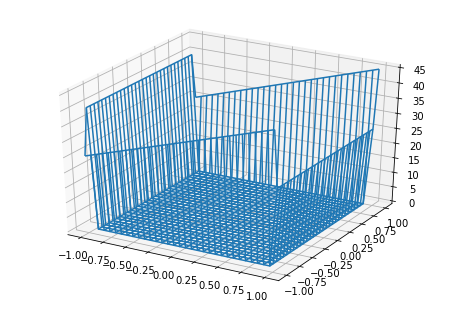

In [41]:
Omega = Domain(1,1800, J=32, N=300)

U0 = np.zeros((32,32))

enforceDirich(Omega, U0, f, 1)
graphe(Omega, U0)

In [42]:
anim = HeatAnimation(Omega, U0, f)

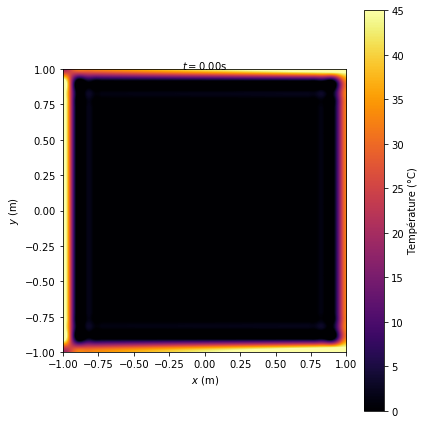

In [43]:
anim.evolHeat()

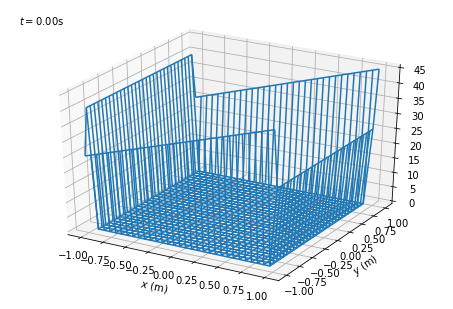

In [18]:
anim.evolSurface()

# Test 2: distribution en cloche

Avec condition initiale $$u_0(x,y) = T\exp\left(-\frac{x^2+y^2}{2\gamma^2}\right), $$ où $\gamma > 0$ est le rayon à mi-hauteur de la cloche.

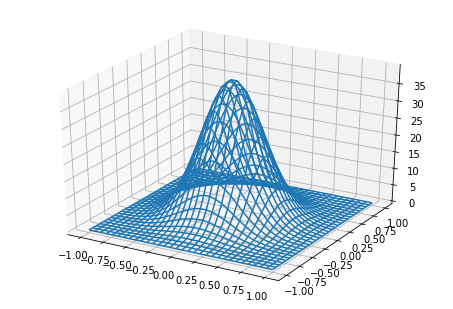

In [47]:
Omega = Domain(1,1800, J=32, N=300)
gamma = 0.3
U0 = 40*distrib(*Omega(), beta = 1/(2*gamma**2))

condBord = (lambda x, y,t : 0)
enforceDirich(Omega, U0, condBord, 1)

graphe(Omega,U0)

In [48]:
animG = HeatAnimation(Omega, U0, condBord)

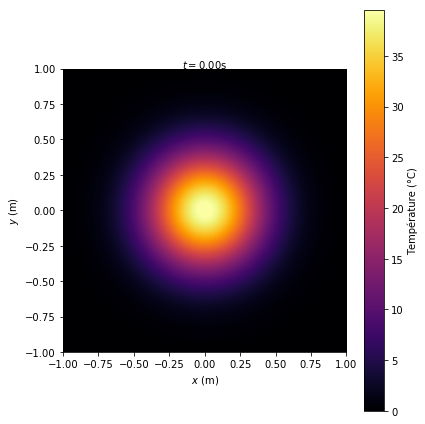

In [49]:
animG.evolHeat()

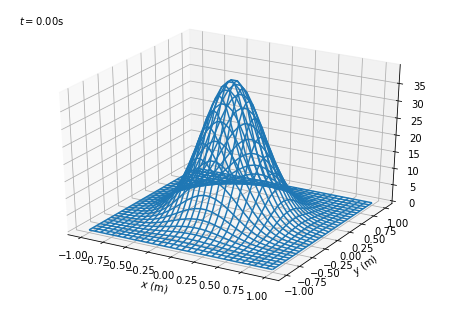

In [37]:
anim.evolSurface()